# 라이브러리 불러오기

In [6]:
import os
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.neighbors import BallTree


# 랜덤 시드 설정

In [7]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# 데이터 불러오기

In [8]:
TRAIN_PATH = '../data/train.csv'
TEST_PATH = '../data/test.csv'
SAMPLE_PATH = '../data/sample_submission.csv'
PARK_PATH = '../data/parkInfo.csv'
SCHOOL_PATH = '../data/schoolinfo.csv'
SUBWAY_PATH = '../data/subwayInfo.csv'

In [9]:
train_data = pd.read_csv(TRAIN_PATH)
test_data = pd.read_csv(TEST_PATH)
sample_submission = pd.read_csv(SAMPLE_PATH)

# 데이터 EDA 수행하기

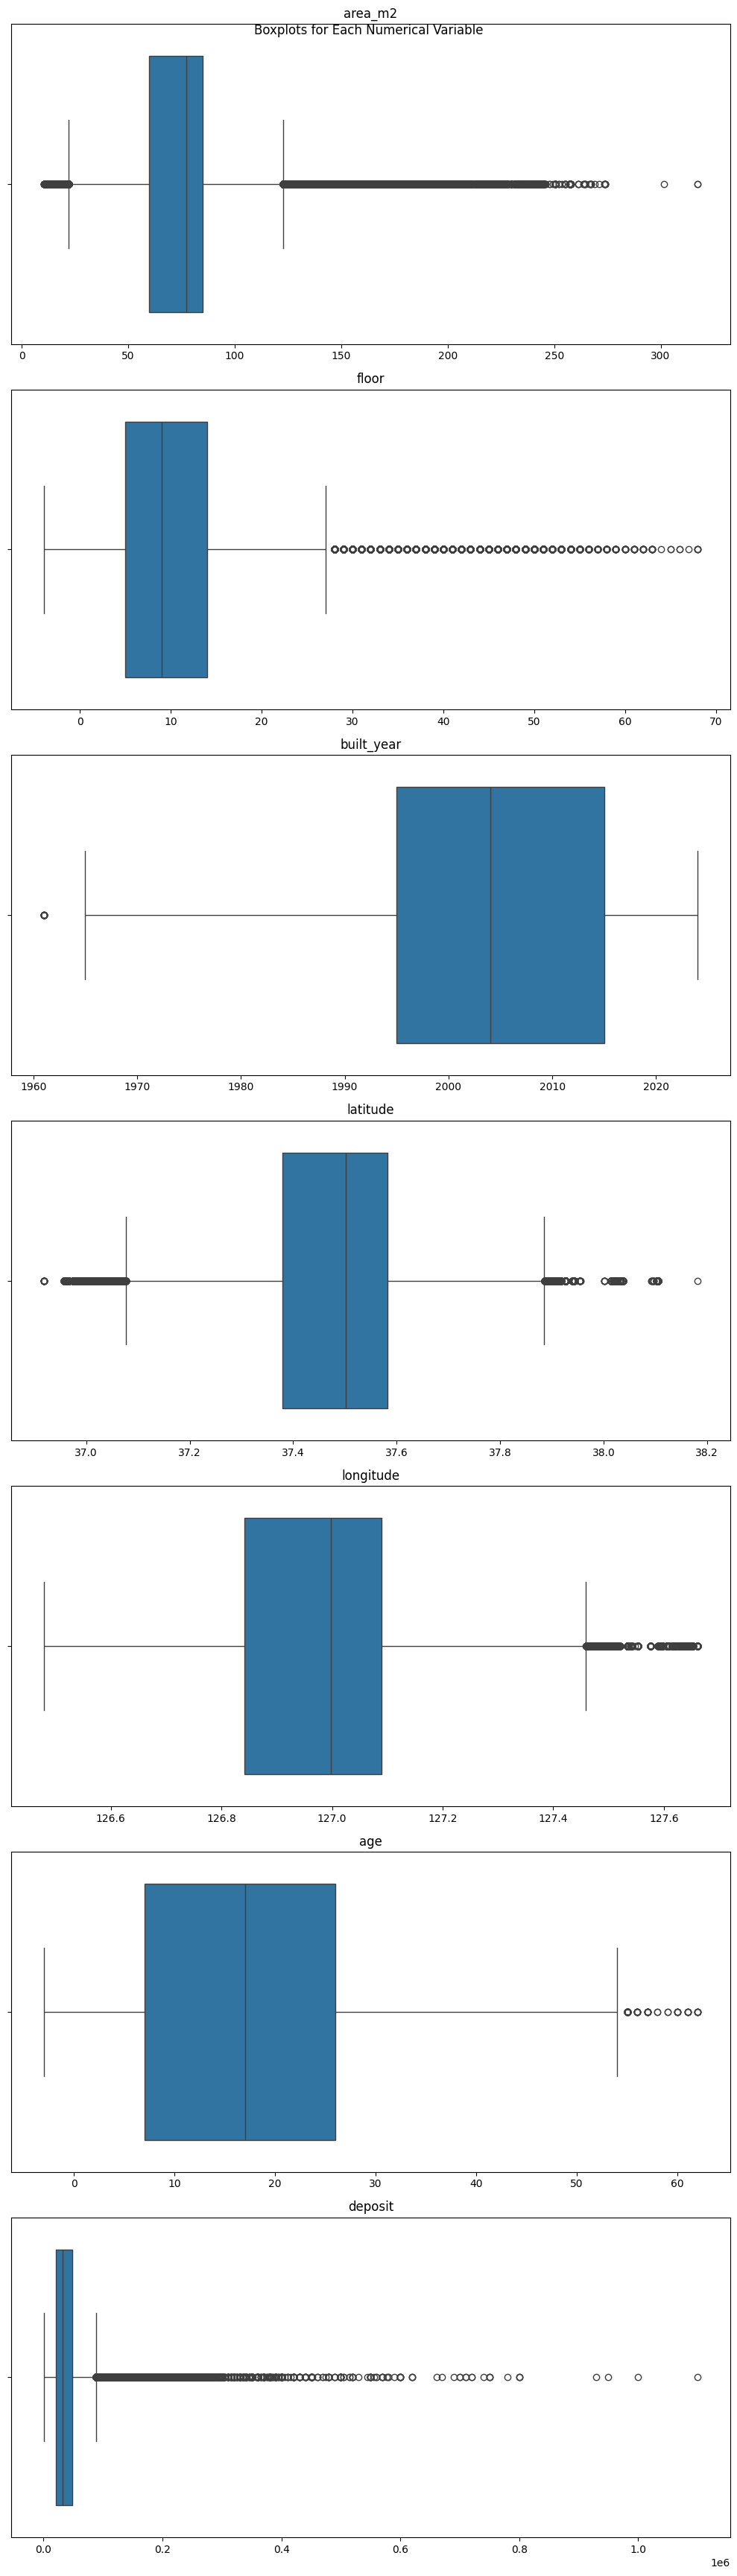

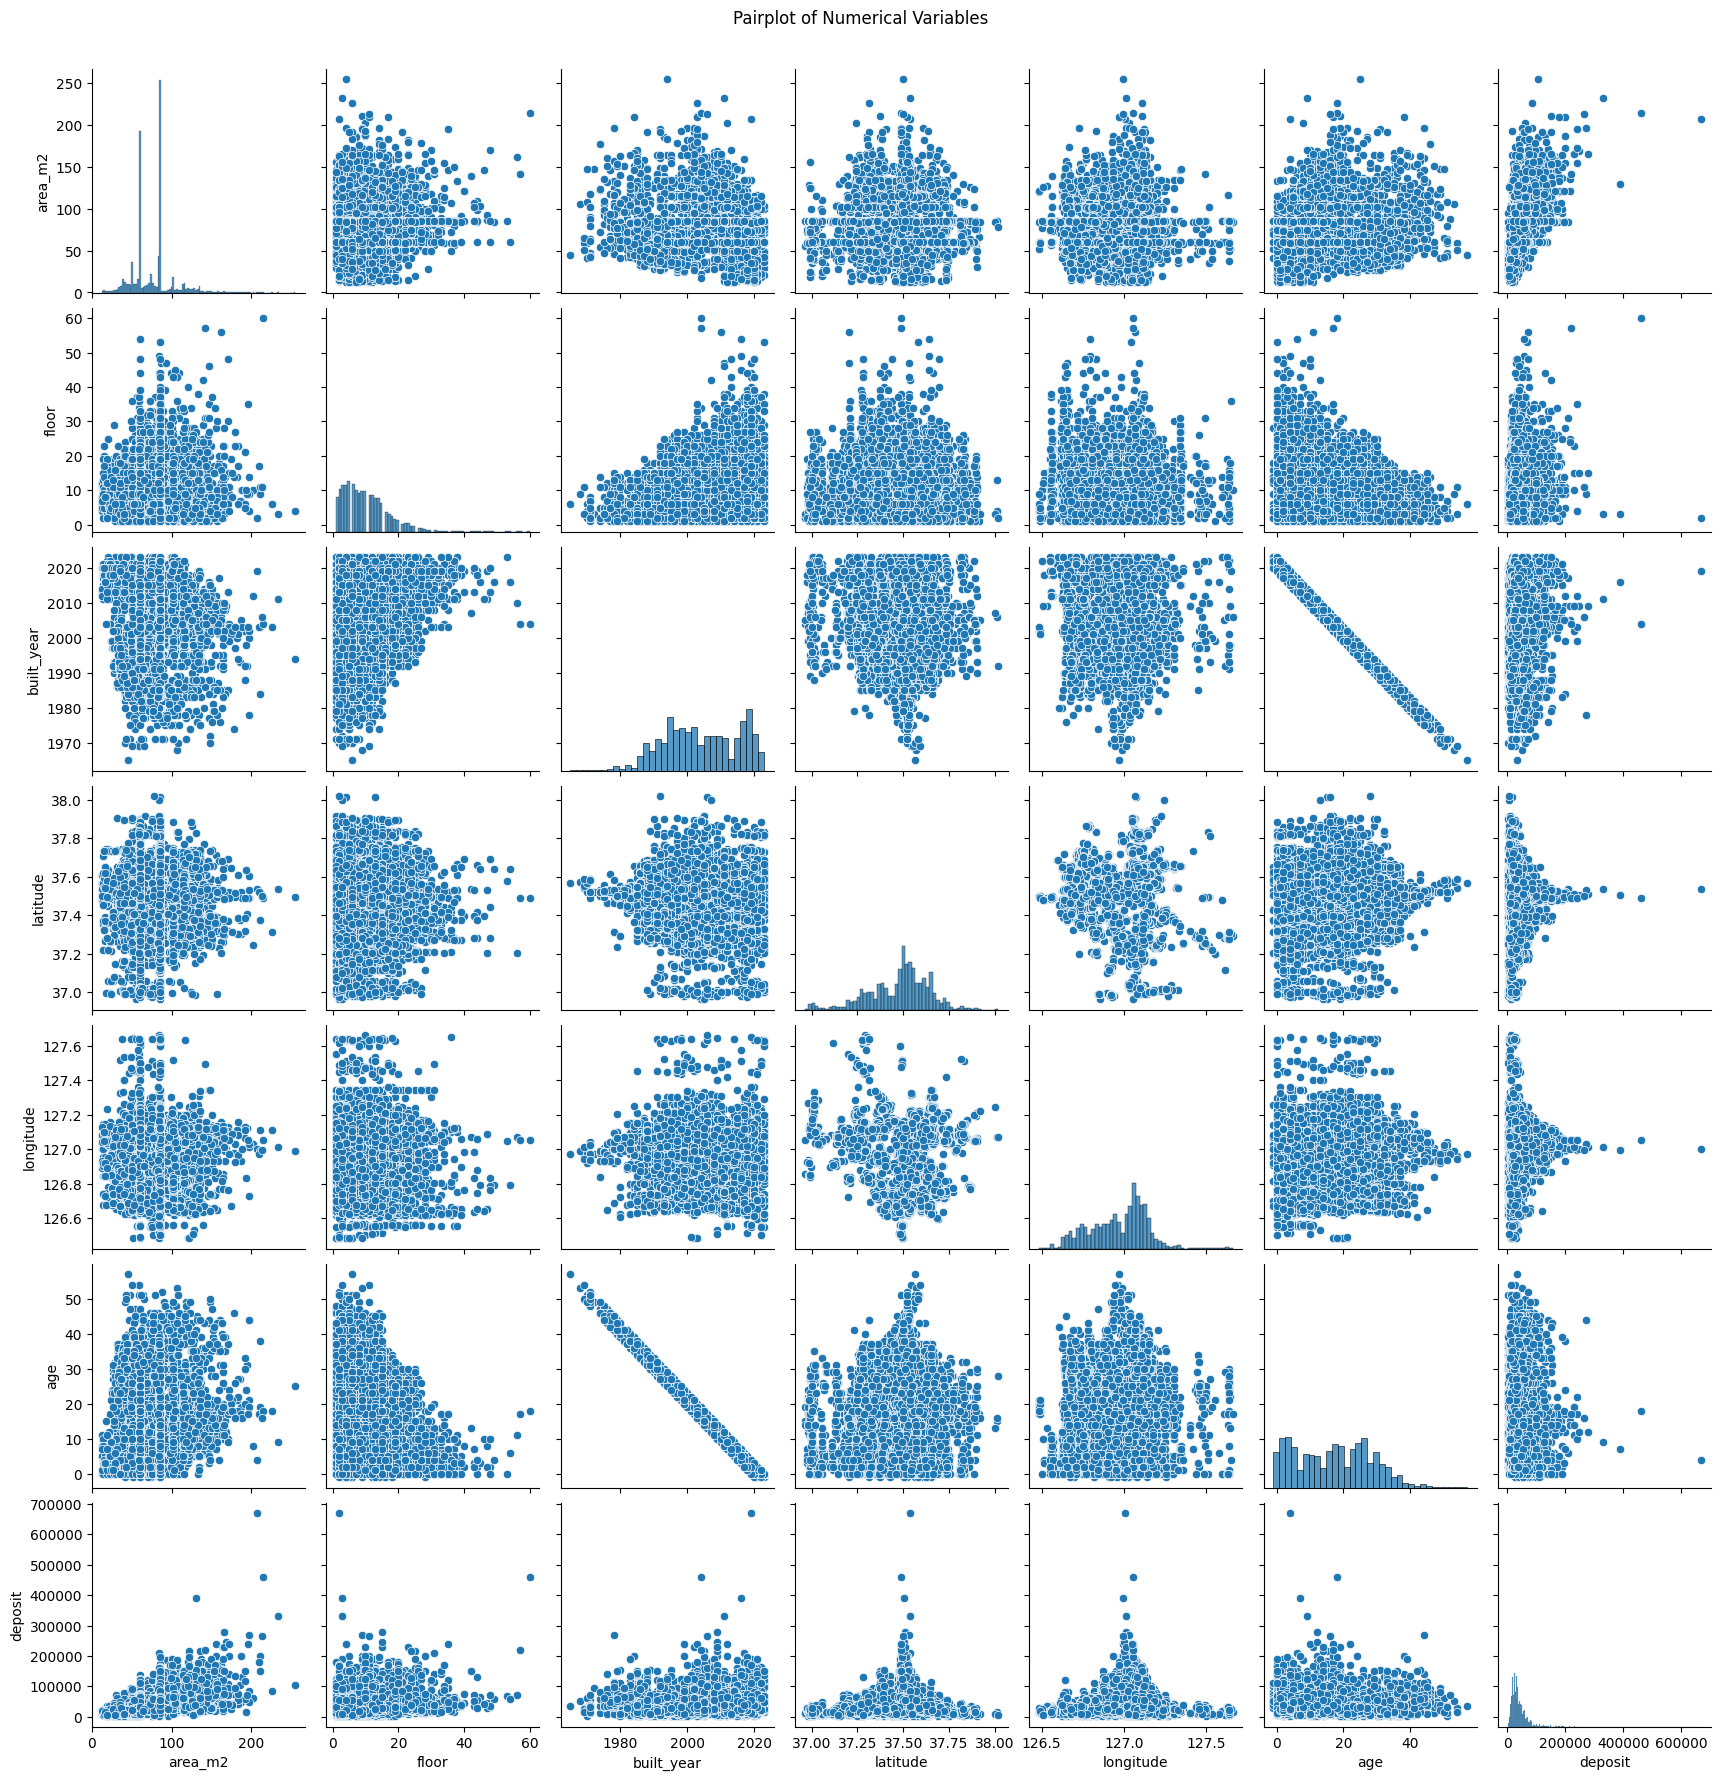

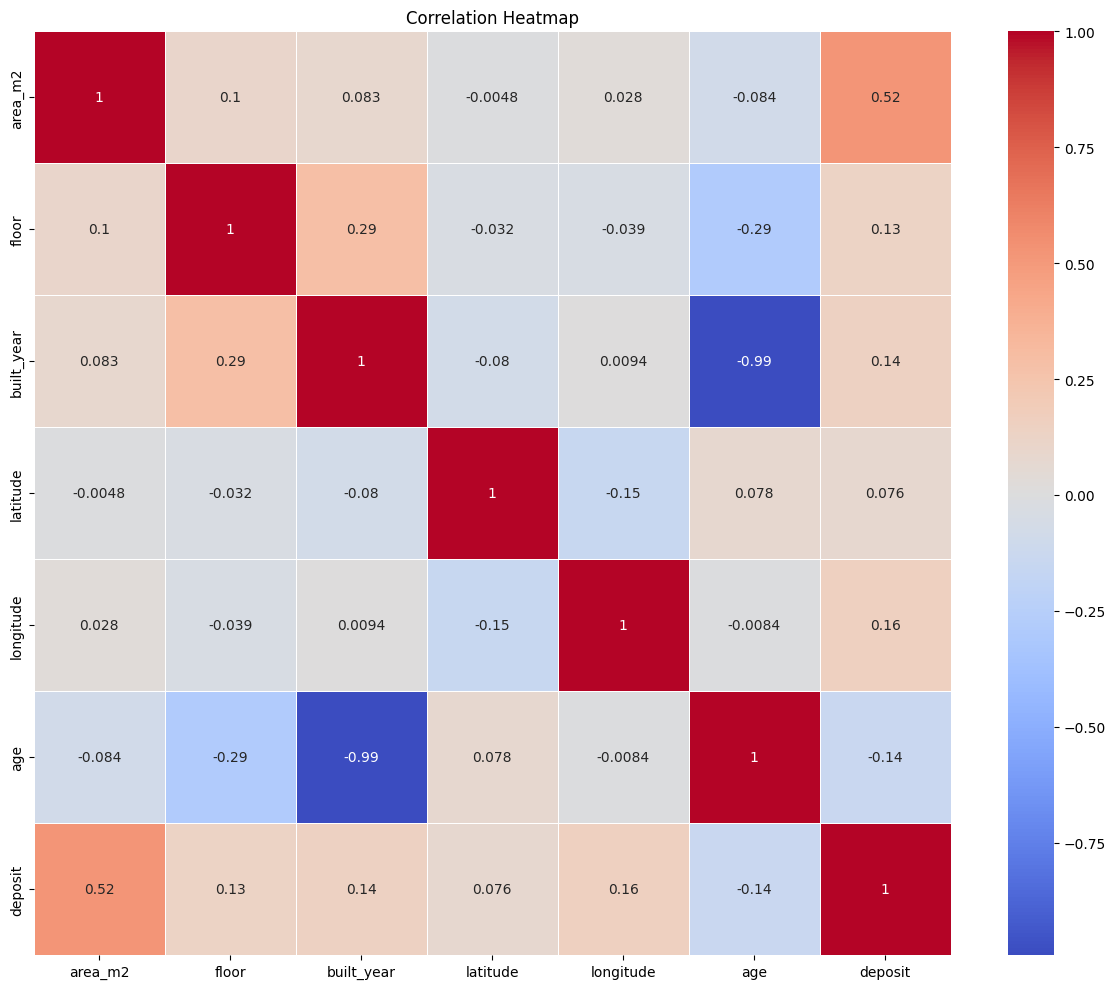

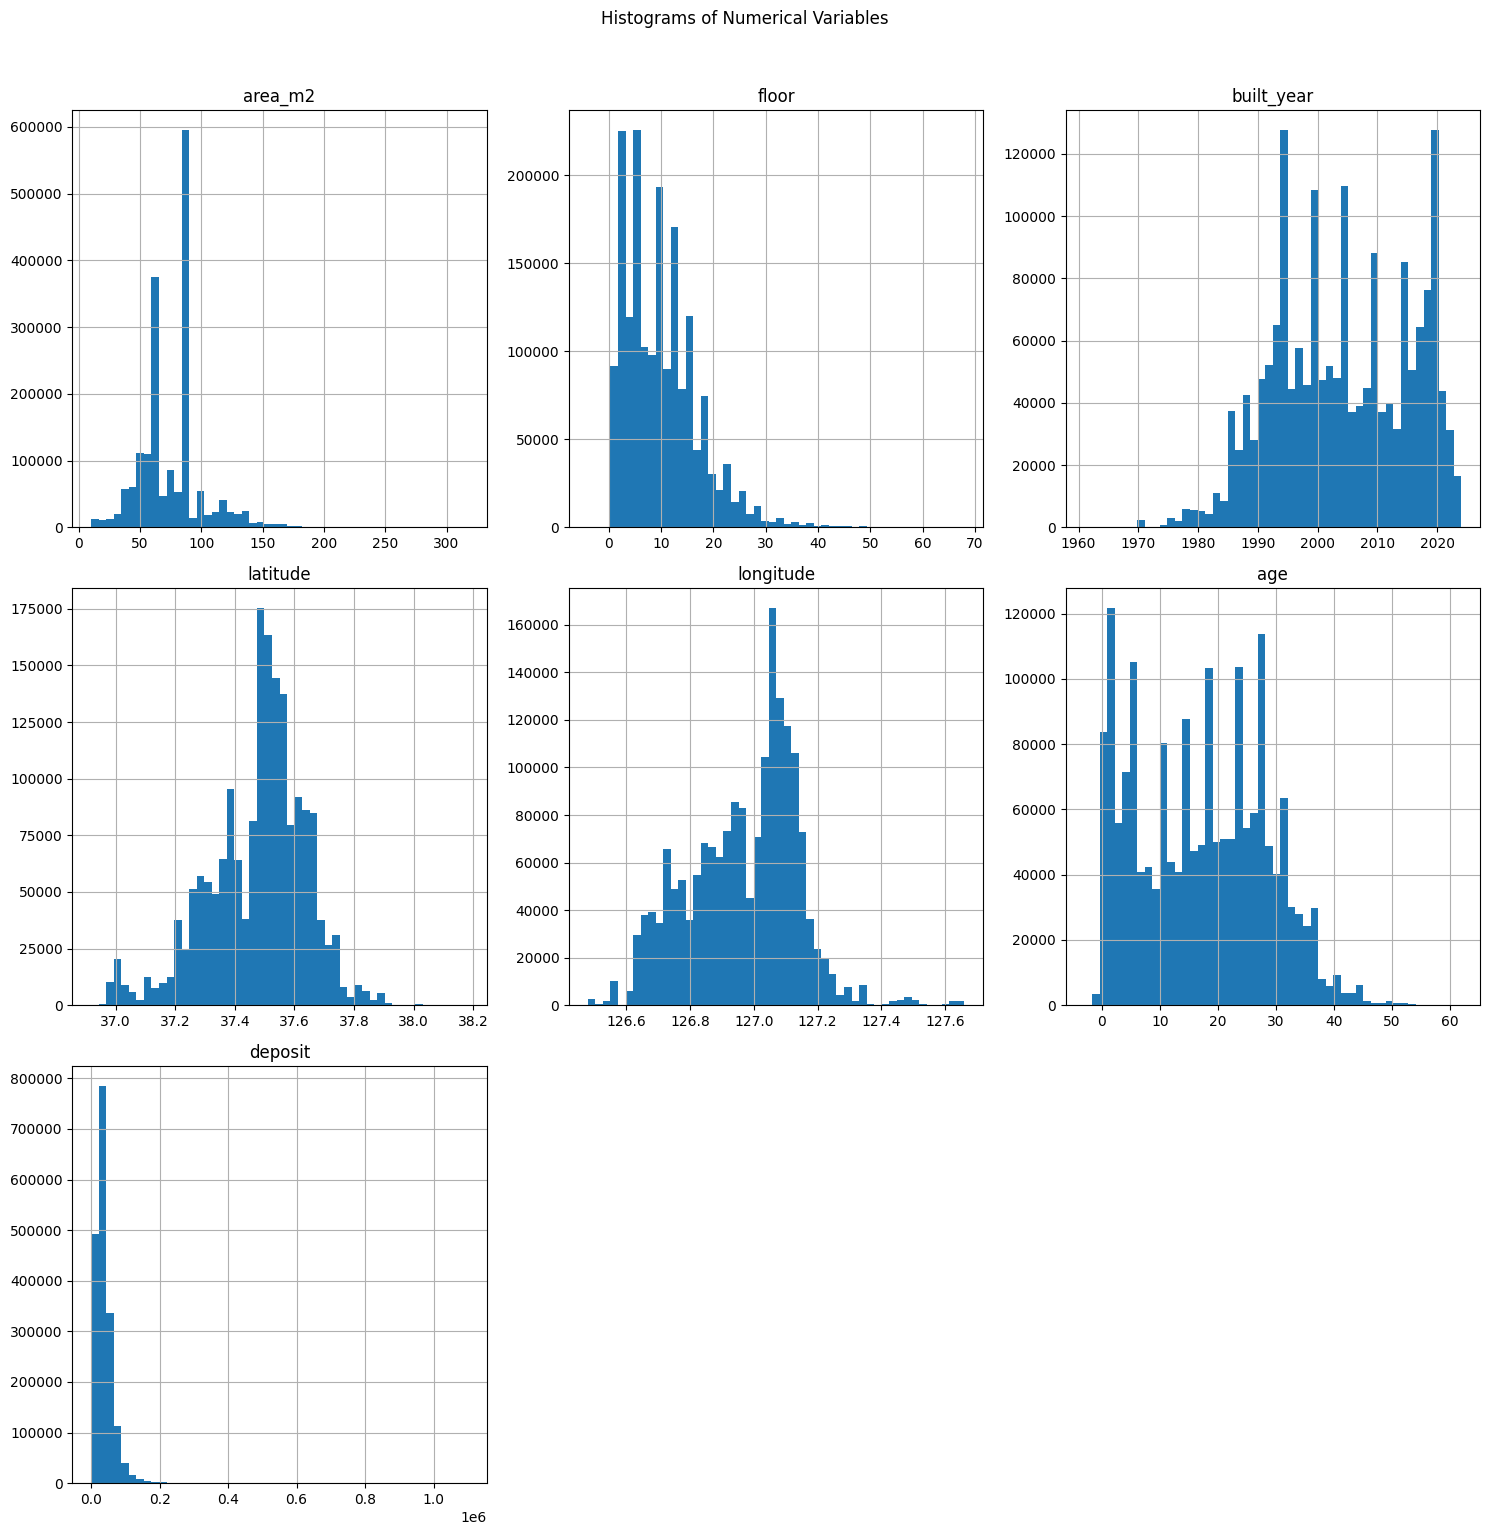

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 로드
df = train_data

# 1. 각 열의 boxplot을 따로 보기
numerical_columns = ['area_m2', 'floor', 'built_year', 'latitude', 'longitude', 'age', 'deposit']

fig, axes = plt.subplots(len(numerical_columns), 1, figsize=(10, 5*len(numerical_columns)))
fig.suptitle('Boxplots for Each Numerical Variable')

for i, column in enumerate(numerical_columns):
    sns.boxplot(x=df[column], ax=axes[i])
    axes[i].set_title(column)
    axes[i].set_xlabel('')

plt.tight_layout()
plt.show()

# 2. Pairplot 추가
# 데이터의 크기가 크므로, 샘플링하여 pairplot 생성
sample_size = 10000  # 적절한 샘플 크기를 선택하세요
df_sample = df.sample(n=sample_size, random_state=42)

sns.pairplot(df_sample[numerical_columns])
plt.suptitle('Pairplot of Numerical Variables', y=1.02)
plt.show()

# 3. 상관관계 히트맵 (앞서 제공한 코드에 추가)
correlation = df[numerical_columns].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

# 4. 각 변수의 히스토그램 (앞서 제공한 코드에 추가)
df[numerical_columns].hist(figsize=(15, 15), bins=50)
plt.suptitle('Histograms of Numerical Variables', y=1.02)
plt.tight_layout()
plt.show()

## 거리 측정

   nearest_subway_dist  nearest_school_dist  nearest_park_dist  \
0             0.716953             0.156120           0.498619   
1             0.716953             0.156120           0.498619   
2             0.716953             0.156120           0.498619   
3             3.897280             0.214560           0.169840   
4             2.039685             1.708489           0.382402   

   avg_3_nearest_subway_dist  avg_3_nearest_school_dist  \
0                   0.716953                   0.156120   
1                   0.716953                   0.156120   
2                   0.716953                   0.156120   
3                   3.897280                   0.214560   
4                   2.039685                   1.708489   

   avg_3_nearest_park_dist  
0                 0.498619  
1                 0.498619  
2                 0.498619  
3                 0.169840  
4                 0.382402  

상관관계:
deposit                      1.000000
nearest_subway_dist         -

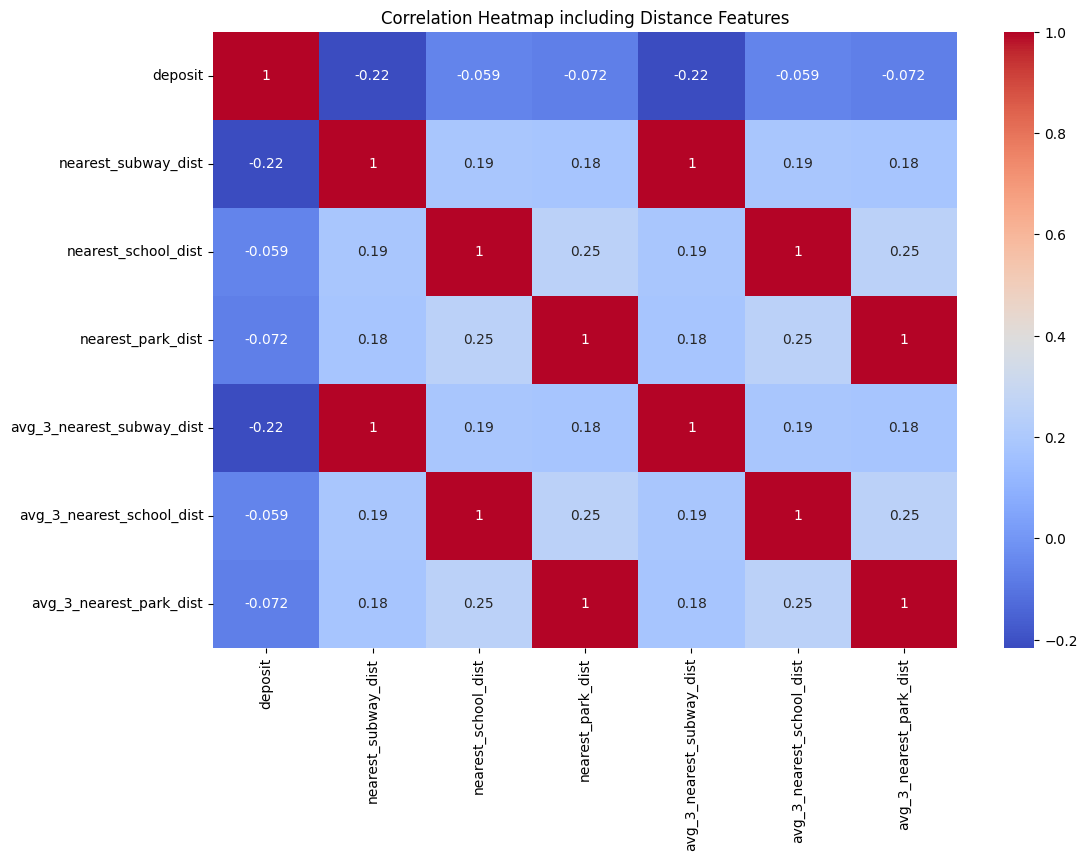

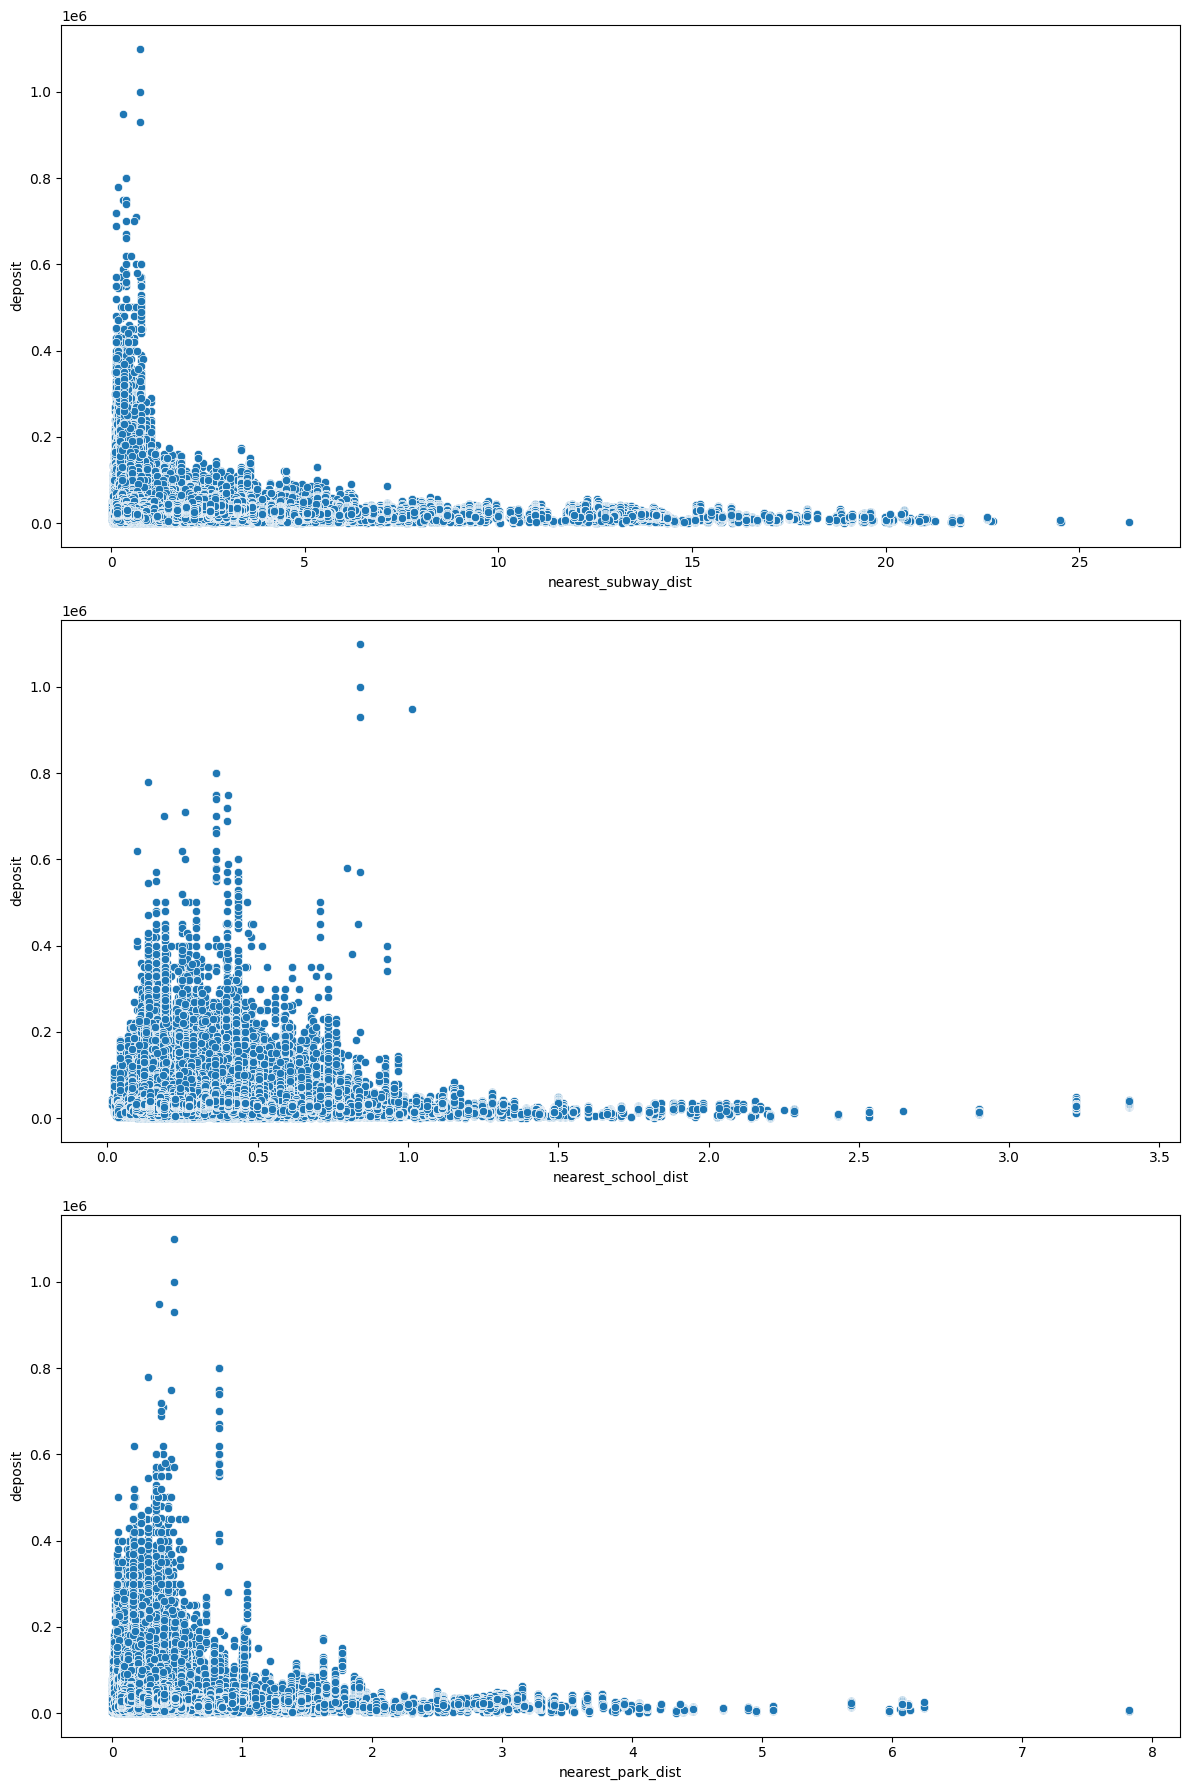

In [13]:
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    위도와 경도를 이용하여 두 지점 간의 거리(km)를 계산합니다.
    """
    R = 6371  # 지구의 반경 (km)
    
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    
    return R * c

def find_nearest_n(df_points, df_targets, n=1):
    """
    각 포인트에 대해 가장 가까운 n개의 타겟 포인트를 찾습니다.
    """
    tree = BallTree(np.deg2rad(df_targets[['latitude', 'longitude']].values), metric='haversine')
    distances, indices = tree.query(np.deg2rad(df_points[['latitude', 'longitude']].values), k=n)
    return distances * 6371, indices  # 라디안을 km로 변환

# 데이터 로드
train_df = pd.read_csv(TRAIN_PATH)
subway_df = pd.read_csv(SUBWAY_PATH)
school_df = pd.read_csv(SCHOOL_PATH)
park_df = pd.read_csv(PARK_PATH)

# 가장 가까운 지하철역, 학교, 공원 찾기
subway_dist, _ = find_nearest_n(train_df, subway_df)
school_dist, _ = find_nearest_n(train_df, school_df)
park_dist, _ = find_nearest_n(train_df, park_df)

# 새로운 특성 추가
train_df['nearest_subway_dist'] = subway_dist.flatten()
train_df['nearest_school_dist'] = school_dist.flatten()
train_df['nearest_park_dist'] = park_dist.flatten()

# 거리의 통계량 계산 (예: 상위 3개의 평균)
_, subway_indices = find_nearest_n(train_df, subway_df, n=3)
_, school_indices = find_nearest_n(train_df, school_df, n=3)
_, park_indices = find_nearest_n(train_df, park_df, n=3)

train_df['avg_3_nearest_subway_dist'] = np.mean(subway_dist, axis=1)
train_df['avg_3_nearest_school_dist'] = np.mean(school_dist, axis=1)
train_df['avg_3_nearest_park_dist'] = np.mean(park_dist, axis=1)

# 결과 확인
print(train_df[['nearest_subway_dist', 'nearest_school_dist', 'nearest_park_dist', 
             'avg_3_nearest_subway_dist', 'avg_3_nearest_school_dist', 'avg_3_nearest_park_dist']].head())

# 상관관계 분석
correlation = train_df[['deposit', 'nearest_subway_dist', 'nearest_school_dist', 'nearest_park_dist',
                     'avg_3_nearest_subway_dist', 'avg_3_nearest_school_dist', 'avg_3_nearest_park_dist']].corr()

print("\n상관관계:")
print(correlation['deposit'])

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap including Distance Features')
plt.show()

# 산점도
fig, axes = plt.subplots(3, 1, figsize=(12, 18))
sns.scatterplot(x='nearest_subway_dist', y='deposit', data=train_df, ax=axes[0])
sns.scatterplot(x='nearest_school_dist', y='deposit', data=train_df, ax=axes[1])
sns.scatterplot(x='nearest_park_dist', y='deposit', data=train_df, ax=axes[2])
plt.tight_layout()
plt.show()

# 데이터 정리

In [ ]:
columns_needed = ['area_m2', 'contract_year_month', 'contract_day', 'contract_type', 'floor', 'latitude', 'longitude', 'deposit']
columns_needed_test = ['area_m2', 'contract_year_month', 'contract_day', 'contract_type', 'floor', 'latitude', 'longitude']
train_data = train_data[columns_needed]
test_data = test_data[columns_needed_test]

In [ ]:
holdout_start = 202307
holdout_end = 202312
holdout_data = train_data[(train_data['contract_year_month'] >= holdout_start) & (train_data['contract_year_month'] <= holdout_end)]
train_data = train_data[~((train_data['contract_year_month'] >= holdout_start) & (train_data['contract_year_month'] <= holdout_end))]

In [ ]:
X_train = train_data.drop(columns=['deposit'])
y_train = train_data['deposit']
X_holdout = holdout_data.drop(columns=['deposit'])
y_holdout = holdout_data['deposit']
X_test = test_data.copy()

# LightGBM 모델 훈련

In [ ]:
lgb_model = lgb.LGBMRegressor(random_state=RANDOM_SEED)
lgb_model.fit(X_train, y_train)

# 성능 확인

In [ ]:
lgb_holdout_pred = lgb_model.predict(X_holdout)
lgb_holdout_mae = mean_absolute_error(y_holdout, lgb_holdout_pred)
print("Holdout 데이터셋 성능:")
print(f"LightGBM MAE: {lgb_holdout_mae:.2f}")

# output

In [ ]:
lgb_test_pred = lgb_model.predict(X_test)
sample_submission['deposit'] = lgb_test_pred
sample_submission.to_csv('output.csv', index=False, encoding='utf-8-sig')